In [1]:
import os
import glob
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns
from datetime import datetime
import calendar
from typing import List, Tuple, Dict
import warnings
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import seaborn as sns
import geopandas as gp
import regionmask
import matplotlib.pyplot as plt
plt.style.use('default')
import cartopy.crs as ccrs
import os
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from collections import namedtuple

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as colors

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import geopandas as gpd
import rioxarray as rio
from shapely.geometry import mapping
from texttable import Texttable
import gcsfs
import geopandas as gpd
from CMIP6_IO import CMIP6_IO

In [2]:
def list_all_model_combinations(prefix, period):
    io = CMIP6_IO()
    files_on_gcs = []
    counter=0
    for blob in io.bucket.list_blobs(prefix=prefix):
        if period in blob.name and "srf" not in blob.name:
            counter+=1
            files_on_gcs.append(blob.name) 
        
    # Variable names
    var_names = np.unique([file.split('/')[-1].split('_')[0] for file in files_on_gcs]).tolist()
    var_names = list(map(lambda x: x.replace("sw","sw_srf"), var_names))
 
    print(var_names)
        
    # Model names
    model_names = np.unique([file.split('/')[-1].split('_')[1] for file in files_on_gcs])
    # Factor names
    factor_names = ["snow_sensitivity", "no_chl", "no_wind", "no_osa", "no_meltpond", "no_clouds"]
    #factor_names = ["osa", "no_chl", "no_wind", "no_osa", "no_meltpond", "snow_sensitivity", "no_ice"]
    # Member IDS
    file_names = np.unique([file.split('/')[-1].split('_')[2] for file in files_on_gcs])
    file_names = [file for file in file_names if file.startswith('r')]
    member_names = np.unique(file_names)

    s="_"
    combined_names=[]
    for var_name in var_names:
        for model_name in model_names:
            for member_name in member_names:
                combined_names.append(s.join([var_name,model_name,member_name]))

    print(f"Total number of files in bucket {counter} and unique variables {len(var_names)} and models {len(model_names)} and combined {len(combined_names)}")
    combos = namedtuple('combos', ['combined_names', 'factor_names', 'model_names'])

    return combos(np.unique(combined_names), factor_names, model_names), files_on_gcs

In [3]:
def get_LME_records():
    lme_file = "gs://actea-shared/Shapefiles/LME66/LMEs66.shp"
    return gpd.read_file(lme_file)

def convert_to_180(ds):
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def get_data_within_LME(ds, LME):
    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
    shdf_sel = shdf[shdf["LME_NAME"] == LME]
    
   # ds = ds.rio.write_crs(4326)
    ds.rio.set_spatial_dims(y_dim="lat", x_dim="lon", inplace=True)
    ds.rio.write_crs(4326,  inplace=True)
    
    clipped = ds.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=ds.rio.crs)
    if "x" in ds.dims:
        clipped = clipped.rename({"x": "lon", "y": "lat"})
   
    return clipped

In [4]:
# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [5]:
def create_seasonal_maps(ds1_seasonal, ds2_seasonal, ds_diff, var_name):
    
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor="lightgray")
    
    # Quick plot to show the results
    notnull = pd.notnull(ds1_seasonal[var_name][0])

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14, 12), subplot_kw={"projection": ccrs.PlateCarree()})
    for i, season in enumerate(("DJF", "MAM", "JJA", "SON")):
        ds1_seasonal[var_name].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 0],
            vmin=0.001,
            vmax=1,
            levels=[0.01,0.02,0.03,0.03,0.04,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.5,0.75,1.0],
            cmap="RdBu_r",
            add_colorbar=True,
            transform=ccrs.PlateCarree(),
            extend="max",
           
        )

        ds2_seasonal[var_name].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 1],
            vmin=0.001,
            vmax=1,
            levels=[0.01,0.02,0.03,0.03,0.04,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.5,0.75,1.0],
            cmap="RdBu_r",
            add_colorbar=True,
            transform=ccrs.PlateCarree(),
            extend="max",
        )

        ds_diff[var_name].sel(season=season).where(notnull).plot.pcolormesh(
            ax=axes[i, 2],
            vmin=-0.01,
            vmax=0.01,
            cmap="RdBu_r",
                levels=[-0.008,-0.007,-0.006,-0.005,-0.004,-0.003,-0.002,-0.001,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008],
            add_colorbar=True,
            transform=ccrs.PlateCarree(),
            extend="both",
        )

        axes[i, 0].set_ylabel(season)
        axes[i, 1].set_ylabel("")
        axes[i, 2].set_ylabel("")
        axes[i, 0].add_feature(land_10m)
        axes[i, 1].add_feature(land_10m)
        axes[i, 2].add_feature(land_10m)
        axes[i, 0].coastlines()
        axes[i, 1].coastlines()
        axes[i, 2].coastlines()
        
    for ax in axes.flat:
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis("tight")
        ax.set_xlabel("")

    axes[0, 0].set_title("Taylor")
    axes[0, 1].set_title(f"{var_name}")
    axes[0, 2].set_title("Difference")

    plt.tight_layout()

    fig.suptitle(f"Seasonal {var_name}", fontsize=16, y=1.02)
    plt.show()
    
def create_distributions(ds1, ds2, name1, name2):
    ds_avg1 = ds1.mean({"lat","lon"})
    ds_avg2 = ds2.mean({"lat","lon"})
    df1 = ds_avg1.to_dataframe()
    df2 = ds_avg2.to_dataframe()
    df1["Status"]=name1
    df2["Status"]=name2
    
    df = pd.concat([df1,df2], axis=0)
    print(df)
    sns.kdeplot(df, x="osa", hue="Status", fill=False, alpha=0.5)
    plt.title(f"{name1} vs {name2}")
    plt.show()

['ghi', 'osa', 'par', 'uv', 'uva', 'uvb', 'uvi']
Total number of files in bucket 896 and unique variables 7 and models 4 and combined 392
[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-01-16_scenario_no_osa_ssp245.nc


/home/tk/.conda/envs/opendrift/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


[CMIP6_IO] Opening file actea-shared/light_sensitivity/ssp245/osa_CanESM5_r10i1p2f1_1979-01-01-1989-01-16_scenario_osa_ssp245.nc


/home/tk/.conda/envs/opendrift/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/tk/.conda/envs/opendrift/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


                 osa  spatial_ref  Status
time                                     
1979-01-31  0.460825            0  Taylor
1979-02-28  0.488180            0  Taylor
1979-03-31  0.483477            0  Taylor
1979-04-30  0.476071            0  Taylor
1979-05-31  0.474527            0  Taylor
...              ...          ...     ...
1988-09-30  0.314324            0     OSA
1988-10-31  0.369926            0     OSA
1988-11-30  0.401416            0     OSA
1988-12-31  0.448855            0     OSA
1989-01-31  0.478211            0     OSA

[242 rows x 3 columns]


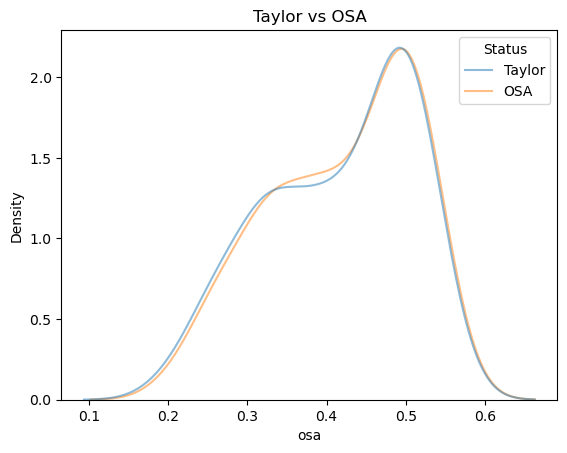

In [6]:
io = CMIP6_IO()
model_var="osa"
LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas']
scenario = "ssp245"
lightpath = "light_sensitivity"
prefix=f'{lightpath}/{scenario}'
models = ['CanESM5']
stats  = {}
factors = ["snow_sensitivity", "no_chl", "no_wind", "no_osa", "no_meltpond", "no_clouds"]
factors = ["no_osa"]
var_name="osa"

period="1979-01-01-1989-01-16"
df = None
create_csv=True
combos, files_on_gcs = list_all_model_combinations(prefix, period)
max_plots=1
counter=0
for LME in LMES:
    for factor in factors:
            for combined_name in combos.combined_names:
                if model_var in combined_name:
                    
                    model = combined_name.split("_")[1]
                    if model in models:
                        file1 = f"light_sensitivity/ssp245/{combined_name}_{period}_scenario_{factor}_ssp245.nc"
                        file2 = f"light_sensitivity/ssp245/{combined_name}_{period}_scenario_osa_ssp245.nc"

                        ds1 = io.open_dataset_on_gs(file1)
                        ds2 = io.open_dataset_on_gs(file2)
                    
                        if ds1 and ds2:
                            ds1=ds1.resample(time='1M').mean() #.sel(time=slice("1979-01-01", "1983-01-01"))
                            ds2=ds2.resample(time='1M').mean()

                            ds1 = get_data_within_LME(ds1, LME).dropna(dim = 'time', how = 'all')
                            ds2 = get_data_within_LME(ds2, LME).dropna(dim = 'time', how = 'all')
                            
                            ds1 = ds1.where(ds1[var_name] != 0, np.nan)
                            ds2 = ds2.where(ds2[var_name] != 0, np.nan)
                            
                            ds1_seasonal = season_mean(ds1)
                            ds2_seasonal = season_mean(ds2)
                            ds_diff = ds1_seasonal - ds2_seasonal
                           # create_seasonal_maps(ds1_seasonal, ds2_seasonal, ds_diff, var_name)
                            create_distributions(ds1, ds2, "Taylor", "OSA")     
                            
                            counter+=1
                            
                        if counter==1:
                            break